**SEASONAL BIKE RENTAL ANALYSIS**

**Business Problem:**
This project aims to optimize bike rental operations in Seoul by leveraging data-driven insights. By analyzing various factors affecting bike rentals, we can improve resource allocation, enhance user experience, and potentially increase revenue for the bike rental service.

**Project Objectives:**
* Identify and quantify the top 3-5 factors influencing bike rental demand in Seoul, providing actionable insights for operational decision-making.
* Develop a regression model to predict hourly bike rental demand with at least 85% accuracy.
* Design and deploy an interactive web application using Streamlit, allowing users to test the regression model through an intuitive interface.

**Specific Questions:**
* What are the most significant factors influencing bike rental demand in Seoul?
How do seasonal changes and weather conditions impact bike rental patterns?
* Are there any trends or patterns in bike rental usage during holidays or specific hours of the day?
* How does air quality (visibility) affect bike rental behavior?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# **DATA EXPLORATION, CLEANING & ANALYSIS**

**LOADING THE DATASET**

In [2]:
data = pd.read_csv('SeoulBikeData.csv', encoding='Windows-1252')

**INSPECTING THE DATASET**

In [3]:
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [5]:
#Remove redundant dependent feature through excel inspection
data = data.drop(columns=['Functioning Day'])

#Making the dependent column as the last column
dependent_column = data.pop('Rented Bike Count')
data['Rented Bike Count'] = dependent_column
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
dtypes: float64(6), int64(4), object(3)
memory usage:

In [7]:
#Converting Date to US format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

#Splitting the features for exploration
#numerical_features = data.select_dtypes(include=['int64', 'float64']).columns --Not using since we want Hour as the time series feature
target_feature = ['Rented Bike Count']
numerical_features = [ 'Temperature(°C)', 'Humidity(%)','Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)','Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']
categorical_features = ['Seasons', 'Holiday']
time_series_features = ['Date','Hour']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Hour                       8760 non-null   int64         
 2   Temperature(°C)            8760 non-null   float64       
 3   Humidity(%)                8760 non-null   int64         
 4   Wind speed (m/s)           8760 non-null   float64       
 5   Visibility (10m)           8760 non-null   int64         
 6   Dew point temperature(°C)  8760 non-null   float64       
 7   Solar Radiation (MJ/m2)    8760 non-null   float64       
 8   Rainfall(mm)               8760 non-null   float64       
 9   Snowfall (cm)              8760 non-null   float64       
 10  Seasons                    8760 non-null   object        
 11  Holiday                    8760 non-null   object        
 12  Rented

**CHECK FOR MISSING VALUES AND DUPLICATES**

In [8]:
missing_values = data.isnull().sum()
missing_values

,0
Date,0
Hour,0
Temperature(°C),0
Humidity(%),0
Wind speed (m/s),0
Visibility (10m),0
Dew point temperature(°C),0
Solar Radiation (MJ/m2),0
Rainfall(mm),0
Snowfall (cm),0


There are no missing values in the dataset

In [9]:
#Check for duplicate values
duplicate_values = data.duplicated().sum()
duplicate_values

0

**ANALYZING NUMERICAL FEATURES**

*STATISTICS*

In [10]:
data.describe(include='all')

,Date,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Rented Bike Count
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760,8760,8760.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spring,No Holiday,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2208,8328,NaN
mean,2018-05-31 23:59:59.999999744,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,NaN,NaN,704.602055
min,2017-12-01 00:00:00,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,2018-03-02 00:00:00,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,NaN,NaN,191.000000
50%,2018-06-01 00:00:00,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,NaN,NaN,504.500000
75%,2018-08-31 00:00:00,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,NaN,NaN,1065.250000
max,2018-11-30 00:00:00,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000,NaN,NaN,3556.000000


In [11]:
most_frequent_values = data.mode().iloc[0]
frequencies = data.apply(lambda x: x.value_counts().iloc[0])

# Combine the results into a DataFrame
results = pd.DataFrame({
    'Most Frequent Value': most_frequent_values,
    'Frequency': frequencies
})

results.T

,Date,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Rented Bike Count
Most Frequent Value,2017-12-01 00:00:00,0.0,19.1,53.0,1.1,2000.0,0.0,0.0,0.0,0.0,Spring,No Holiday,0.0
Frequency,24,365,40,173,420,2245,60,4300,8232,8317,2208,8328,295


*UNI-VARIATE ANALYSIS*

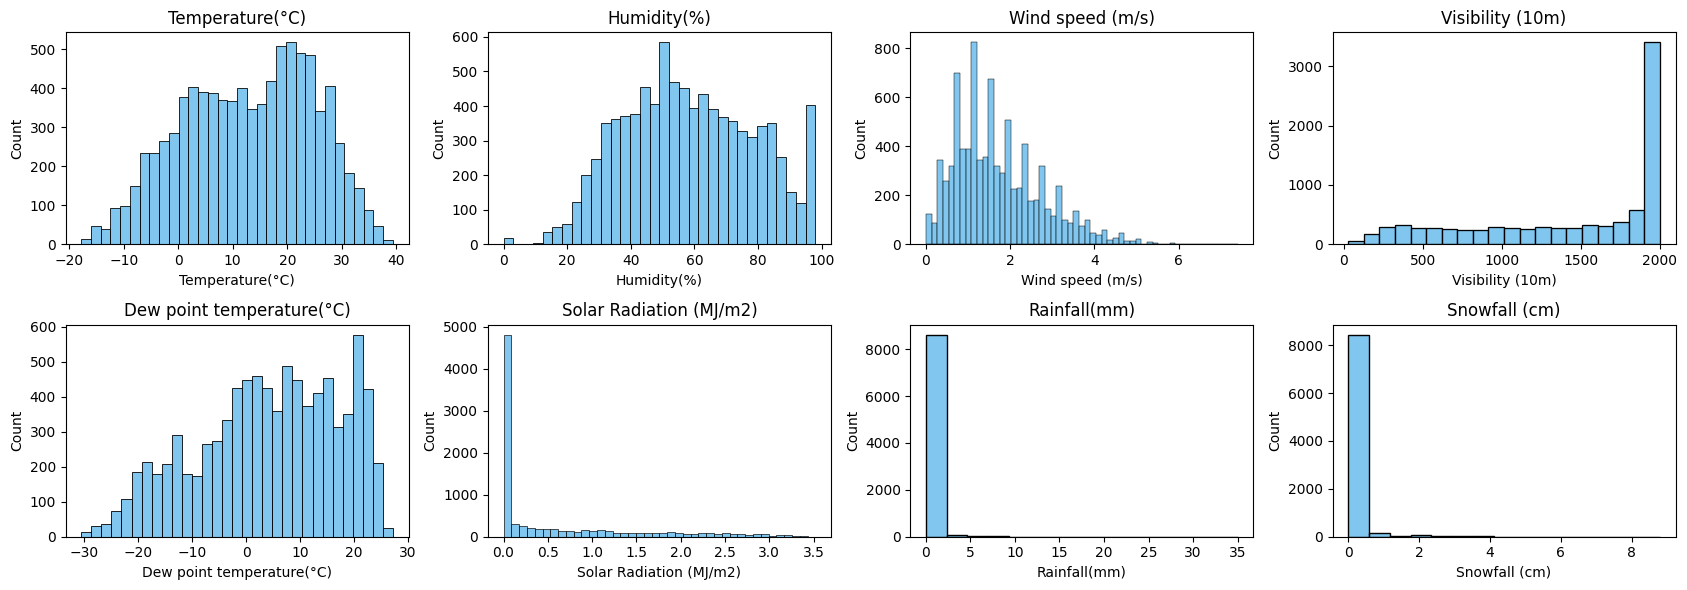

In [12]:
# Initialize the figure
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17, 6))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through numerical features and plot histogram and boxplot
for i, feature in enumerate(numerical_features):
    sns.histplot(data[feature], ax=axes[i], color = '#56B4E9')
    axes[i].set_title(f'{feature}')

plt.tight_layout()
plt.show()

*KEY OBSERVATIONS*

Most of the days observed were:
* Lower Wind Speeds
* High Visibility
* Low Solar Radiation
* Low Rainfall and Snowfall



*BI-VARIATE ANALYSIS*

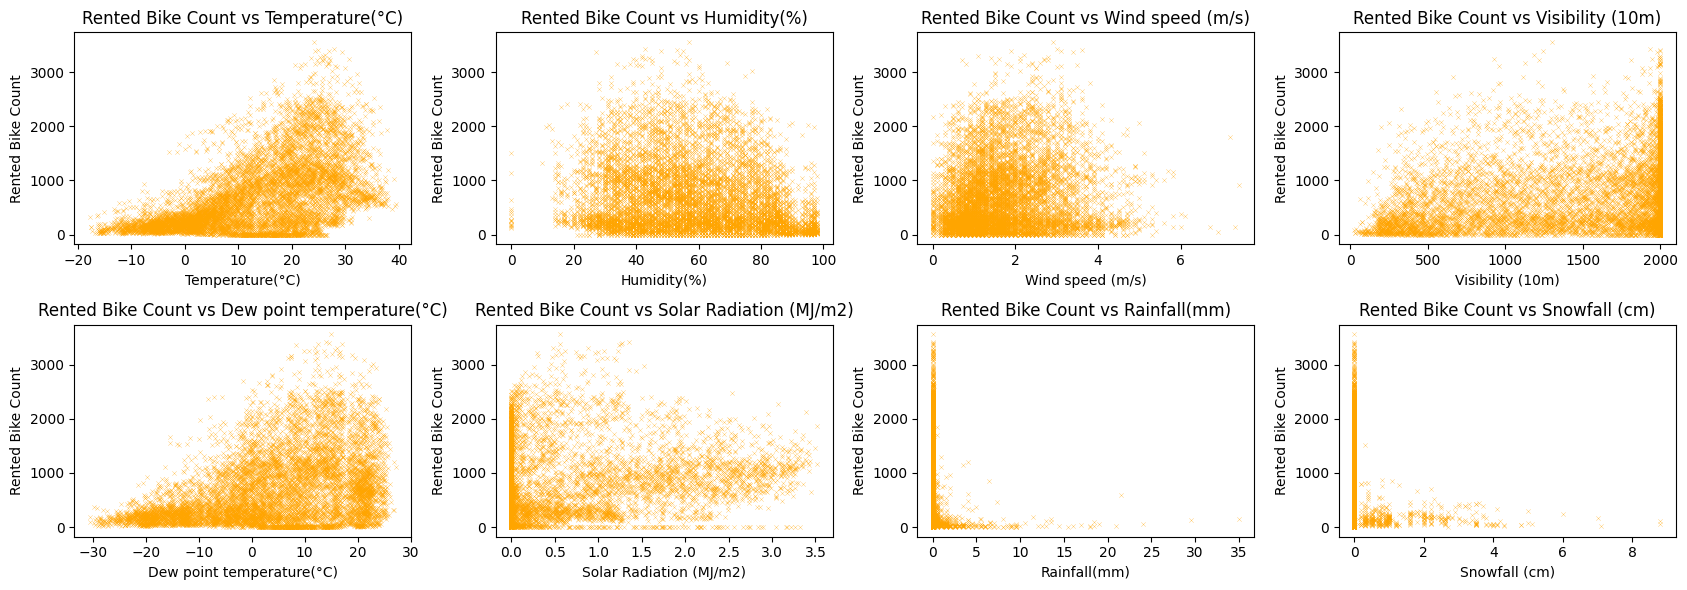

In [13]:
# Initialize the figure
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17, 6))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through numerical features and plot scatterplots
for i, feature in enumerate(numerical_features):
        sns.scatterplot(data = data, x = data[feature], y ='Rented Bike Count', ax=axes[i],color = 'orange', marker = 'x', s = 10, alpha = 0.7)
        axes[i].set_title(f'Rented Bike Count vs {feature}')

plt.tight_layout()
plt.show()

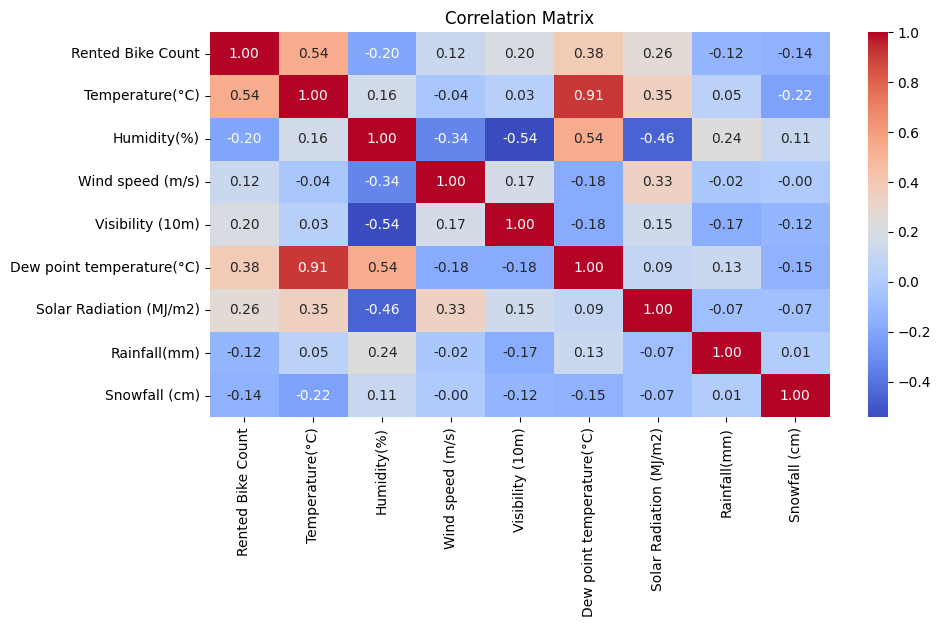

In [14]:
# Add 'Rented Bike Count' to the list of features for correlation matrix
features_for_correlation = ['Rented Bike Count'] + numerical_features

# Compute the correlation matrix
corr_matrix = data[features_for_correlation].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

*KEY OBSERVATIONS*

* Increasing Temperature, Dew and Visibility seem to have the most positive influence on bike rentals
* High rainfall and snowfall seem to have the most negative influence on bike rentals, though they are weakly correlated
* Temperature and Dew: Strong positive correlation, do we need both the variables?
* Humidity and Dew VS Humidity and Temperature: Humidity is moderately correlated with Dew compared to a weak correlation with Temperature. So, this may indicate it might be wise not to drop either Temperature or Dew at this point
* Humidity and Visibility: Moderate negative correlation, indicating that higher humidity often coincides with lower visibility
* Humidity doesn't seem to influence Bike rental drastically as it follows almost a normal distribution with a weak negative correlation




**ANALYZING CATEGORICAL FEATURES**

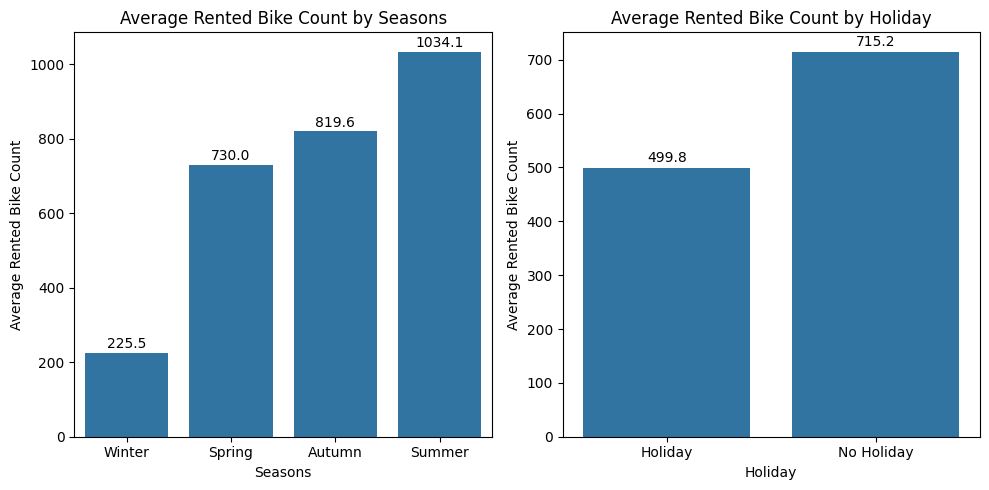

In [15]:
# Initialize the figure with 2 subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Iterate through categorical features and plot on each subplot
for i, feature in enumerate(categorical_features):
    # Calculate the average rented bike count per category
    avg_rented_bike_count = data.groupby(feature)['Rented Bike Count'].mean().sort_values()

    # Create a bar plot on the respective axis
    sns.barplot(ax=axes[i], x=avg_rented_bike_count.index, y=avg_rented_bike_count.values)

    # Add labels on the bars
    for index, value in enumerate(avg_rented_bike_count.values):
        axes[i].text(index, value + 5, f'{value:.1f}', ha='center', va='bottom')

    # Add title and labels
    axes[i].set_title(f'Average Rented Bike Count by {feature}')
    axes[i].set_ylabel('Average Rented Bike Count')
    axes[i].set_xlabel(feature)

plt.tight_layout()
plt.show()


*KEY OBSERVATIONS*

On an average, Bike rentals seem to be
* Highest during the summer and lowest during the winter
* Lower during Holidays

**ANALYZING TIME SERIES FEATURES**

In [17]:
# Extract additional date features
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
#Year didn't feel useful as it's a 1 year data with only 1 month from 2017 and rest in 2018

hour_column = data.pop('Hour')
dependent_column = data.pop('Rented Bike Count')
data['Hour'] = hour_column
data['Rented Bike Count'] = dependent_column

data.head()

,Date,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Month,Day,Hour,Rented Bike Count
0,2017-12-01,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,1,0,254
1,2017-12-01,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,1,1,204
2,2017-12-01,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,12,1,2,173
3,2017-12-01,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,1,3,107
4,2017-12-01,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,12,1,4,78


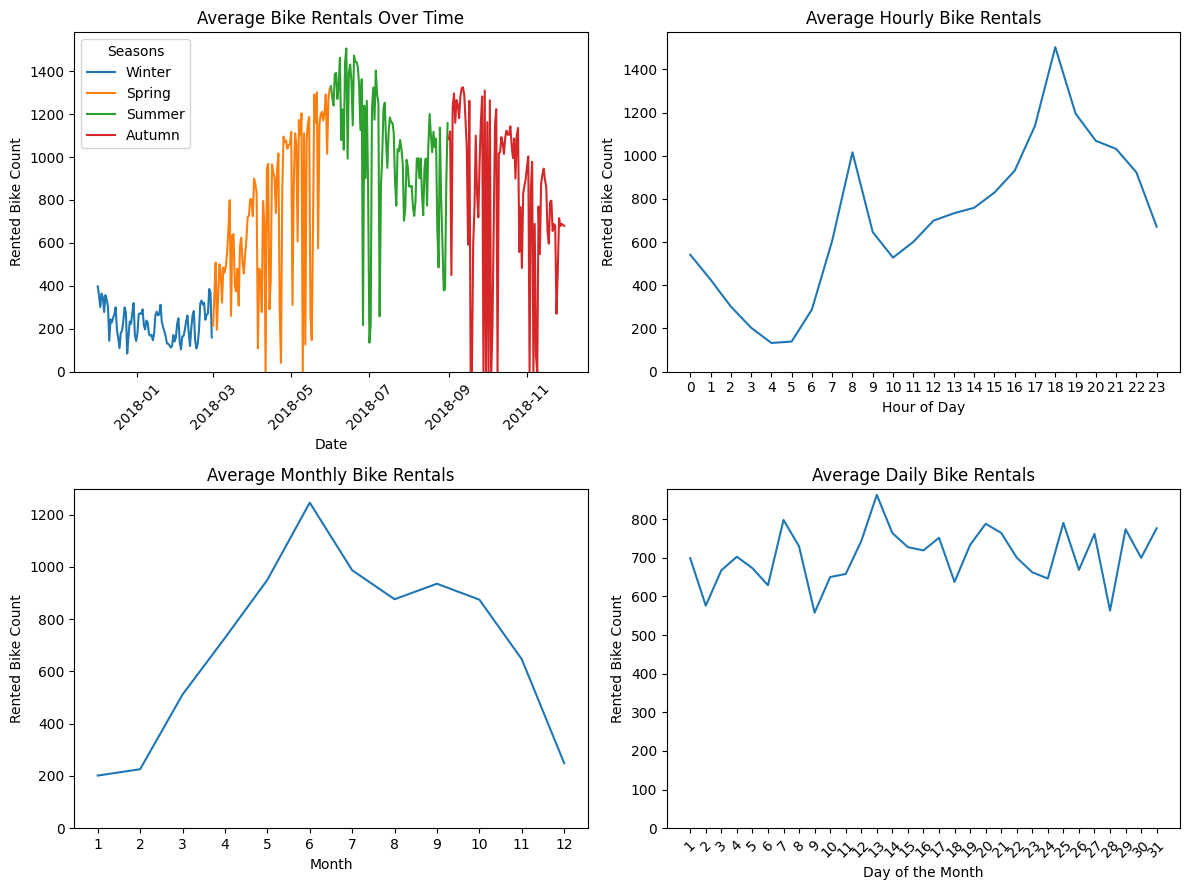

In [18]:
# Initialize the figure with 2 rows and 2 columns of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))

# Plot 1: Daily rentals over time, colored by season
daily_rentals_with_season = data.groupby(['Date', 'Seasons'])['Rented Bike Count'].mean().reset_index()
sns.lineplot(ax=axes[0, 0], data=daily_rentals_with_season, x='Date', y='Rented Bike Count', hue='Seasons', palette='tab10')
axes[0, 0].set(title='Average Bike Rentals Over Time', xlabel='Date', ylabel='Rented Bike Count')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylim(0)

# Plot 2: Average hourly rentals
hourly_rentals = data.groupby('Hour')['Rented Bike Count'].mean()
sns.lineplot(ax=axes[0, 1], x=hourly_rentals.index, y=hourly_rentals.values)
axes[0, 1].set(title='Average Hourly Bike Rentals', xlabel='Hour of Day', ylabel='Rented Bike Count')
axes[0, 1].set_xticks(range(0, 24))
axes[0, 1].set_ylim(0)

# Plot 3: Average monthly rentals
monthly_rentals = data.groupby('Month')['Rented Bike Count'].mean()
sns.lineplot(ax=axes[1, 0], x=monthly_rentals.index, y=monthly_rentals.values)
axes[1, 0].set(title='Average Monthly Bike Rentals', xlabel='Month', ylabel='Rented Bike Count')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_ylim(0)

# Plot 4: Average daily rentals by day of the month
daily_rentals = data.groupby('Day')['Rented Bike Count'].mean()
sns.lineplot(ax=axes[1, 1], x=daily_rentals.index, y=daily_rentals.values)
axes[1, 1].set(title='Average Daily Bike Rentals', xlabel='Day of the Month', ylabel='Rented Bike Count')
axes[1, 1].set_xticks(range(1, 32))
axes[1, 1].set_ylim(0)
axes[1, 1].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

*KEY OBSERVATIONS*

* There is a cyclical pattern with rentals rising as the weather warms up and falling as it gets colder, with noticeable dip during Winter.
* Zero bike rental days were only observed during Spring and Autumn
* There is a clear pattern in bike rentals peaking around 8am and 6pm which corresponds to typical commuting hours
* There is a drop in bike rentals during early morning and late night hours
* Bike rentals seem to be at it's peak during June
* On an average, there is a peak in the 13th day of the month while a decline in the 9th and 28th day of the month.

In [19]:
#Dropping the Date Column
data = data.drop(columns = 'Date')
data

,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Month,Day,Hour,Rented Bike Count
0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,1,0,254
1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,1,1,204
2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,12,1,2,173
3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,12,1,3,107
4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,12,1,4,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,11,30,19,1003
8756,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,11,30,20,764
8757,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,11,30,21,694
8758,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,11,30,22,712


**OUTLIER DETECTION**

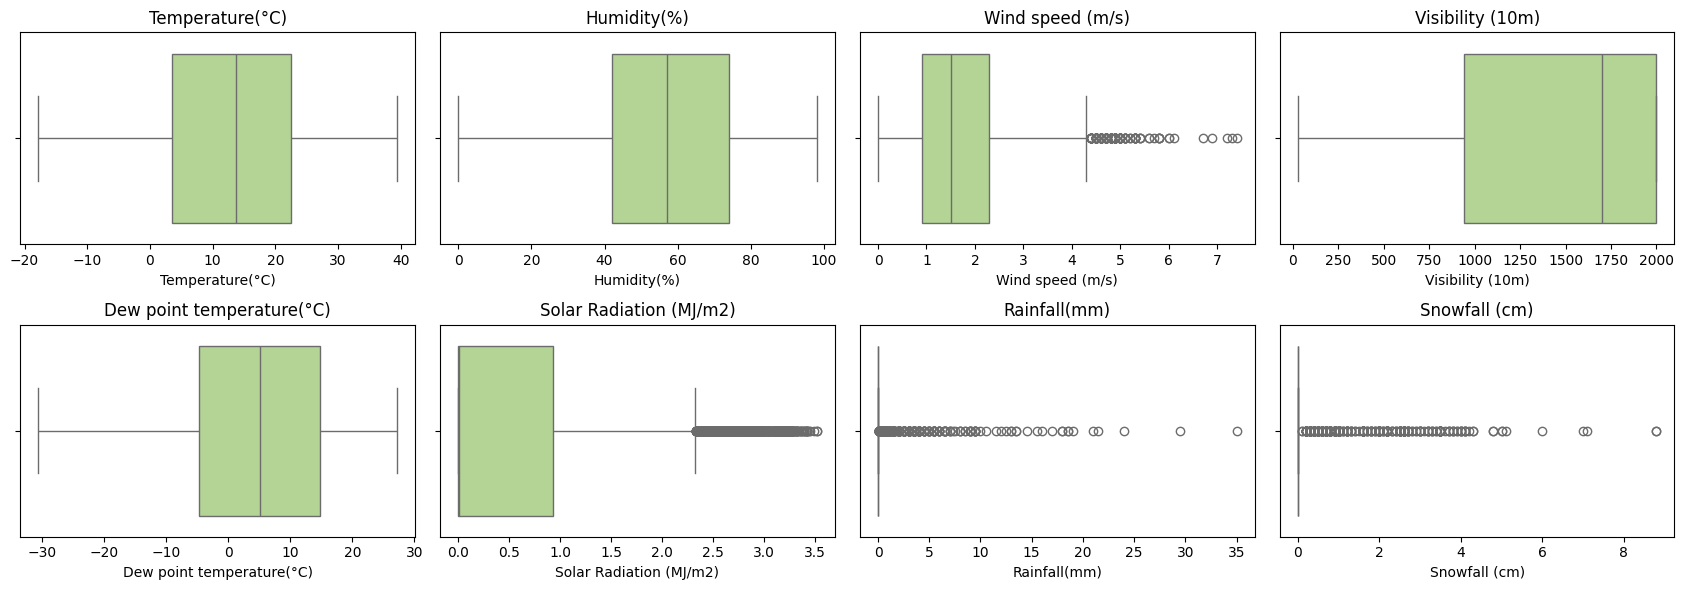

In [20]:
# Initialize the figure
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17, 6))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through numerical features and plot histogram and boxplot
for i, feature in enumerate(numerical_features):
    sns.boxplot(x=data[feature], ax=axes[i], color = '#B2DF8A')
    axes[i].set_title(f'{feature}')

plt.tight_layout()
plt.show()

In [21]:
outlier_features = ['Wind speed (m/s)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

data_outlier_handled = data

for feature in outlier_features:
  Q1 = data_outlier_handled[feature].quantile(0.25)
  Q3 = data_outlier_handled[feature].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = len(np.where((data_outlier_handled[feature].values < lower_bound) | (data_outlier_handled[feature].values > upper_bound))[0])
  print(f'{feature} Outliers: {outliers}')
  data_outlier_handled = data_outlier_handled[~((data_outlier_handled[feature].values < lower_bound) | (data_outlier_handled[feature].values > upper_bound))]
print(f'Outliers that will be removed if we use IQR: {round(((data.shape[0]-data_outlier_handled.shape[0])/data.shape[0])*100,2)}%')#

Wind speed (m/s) Outliers: 161
Solar Radiation (MJ/m2) Outliers: 682
Rainfall(mm) Outliers: 513
Snowfall (cm) Outliers: 398
Outliers that will be removed if we use IQR: 20.02%


*THOUGHT PROCESS*
* If I try to remove all outliers outside the IQR, it is removing 20% of the dataset which I'm not comfortable with
* In Seoul, the following is rare:
-- Wind Speed - above 15 m/s
-- Solar Radiation - above 25 MJ/m²
-- Rainfall (mm) - exceeding 100 mm
-- Snowfall(cm) - more than 10 cm

The dataset values fall well within this range, so I'm choosing to keep the outliers for now.

**HANDLING CATEGORICAL FEATURES**

In [22]:
# Display unique values
for feature in categorical_features:
  print(f'{feature}: {data[feature].unique()}')

Seasons: ['Winter' 'Spring' 'Summer' 'Autumn']
Holiday: ['No Holiday' 'Holiday']


In [23]:
# Identify the category with the highest frequency for each feature
most_frequent_season = data['Seasons'].value_counts().idxmax()
most_frequent_holiday = data['Holiday'].value_counts().idxmax()

most_frequent_season,most_frequent_holiday

('Spring', 'No Holiday')

In [24]:
# Generate dummy variables, dropping the most frequent category in each case
data_with_dummies = pd.get_dummies(data, columns = categorical_features)
data_dummies_clean = data_with_dummies.drop(columns=[f'Seasons_{most_frequent_season}', f'Holiday_{most_frequent_holiday}'])
#data_dummies_clean.head(10)

#Making the dependent column as the last column
dependent_column = data_dummies_clean.pop('Rented Bike Count')
data_dummies_clean['Rented Bike Count'] = dependent_column
data_dummies_clean.head()

,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Month,Day,Hour,Seasons_Autumn,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Rented Bike Count
0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,12,1,0,False,False,True,False,254
1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,12,1,1,False,False,True,False,204
2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,12,1,2,False,False,True,False,173
3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,12,1,3,False,False,True,False,107
4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,12,1,4,False,False,True,False,78


**TRAINING AND TEST SET CREATION**

In [25]:
X = data_dummies_clean.iloc[:, :-1].values
y = data_dummies_clean.iloc[:, -1].values
X, y

(array([[-5.2, 37, 2.2, ..., False, True, False],
        [-5.5, 38, 0.8, ..., False, True, False],
        [-6.0, 39, 1.0, ..., False, True, False],
        ...,
        [2.6, 39, 0.3, ..., False, False, False],
        [2.1, 41, 1.0, ..., False, False, False],
        [1.9, 43, 1.3, ..., False, False, False]], dtype=object),
 array([254, 204, 173, ..., 694, 712, 584]))

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7008, 15), (1752, 15), (7008,), (1752,))

**FEATURE SCALING**

In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train=sc.fit_transform(X_train)

In [29]:
X_train

array([[-0.38874606,  0.18996015, -1.08168277, ..., -0.57910781,
         1.7507042 , -0.23202281],
       [ 1.29850393, -0.05608294,  0.64784699, ...,  1.72679419,
        -0.57119872, -0.23202281],
       [ 1.42379477, -0.05608294, -0.02474792, ...,  1.72679419,
        -0.57119872, -0.23202281],
       ...,
       [ 1.05627497, -0.05608294,  0.07133707, ...,  1.72679419,
        -0.57119872, -0.23202281],
       [-0.38039334,  0.0423343 ,  0.35959203, ..., -0.57910781,
        -0.57119872, -0.23202281],
       [-0.48062601,  1.22334111,  1.51261186, ..., -0.57910781,
        -0.57119872, -0.23202281]])

# **EDA SUMMARY**

* There were no missing or duplicate values in the dataset.
* There is a seasonal trend in bike rentals peaking during warmer months and dipping during colder months.
* Interestingly, even though Winter had the least rentals, the only zero rental days were during Spring and Autumn.
* There is an increase in bike rentals during typical commuting hours of morning 8am and evening 6pm.
* Rentals seem to be lesser during Holidays.
* Temperature and Dew seem to strongly influence bike rentals. Even though both are highly correlated, they are being kept in the data as their correlations with other features varies.
* Humidity doesn't seem to noticeably affect bike rentals, but I wonder if it indirectly influences rentals through other mutually correlated features.
* Lower Wind Speeds, high Visibility, low Solar Radiation and low Rainfall/Snowfall seem to have the most rentals, but most of the days observed were such days as well. So, given the weak coorelation with Bike rentals, there isn't enough evidence yet to say how influential they are on rentals.
* At this point, no outliers has been removed as the collected weather data seem to be within the typical range in Seoul.
